## Zipline backtest

In [2]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
from datetime import datetime as dt
import glob
# from modules.utils import *
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar

from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
import seaborn as sns
from scipy import stats

# from exchange_calendars.exchange_calendar_xdse import XDSExchangeCalendar
# register_calendar("XDSE", XDSExchangeCalendar())

# import pyfolio as pf
#from pyfolio.utils import extract_rets_pos_txn_from_zipline
# import mplfinance as mpf
# import MyTT as mpq
# from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
#                      INFO, WARNING, DEBUG, ERROR)
%load_ext autoreload

In [3]:
bundle = 'quandl'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
tickers = [coin.symbol for coin in assets]

### Single asset backtest with dynamic signals

In [5]:
start = '2010-01-15'
end = '2016-01-01'
capital_base = 100000
symb = 'AAPL'
window = 90

def initialize(context):
    context.i = 0
    context.asset = symbol(symb)


def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 200:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=90, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=200, frequency="1d").mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
           short_mavg=short_mavg,
           long_mavg=long_mavg)

result = run_algorithm(start=pd.Timestamp(start,tz='utc'),
                        end=pd.Timestamp(end,tz='utc'),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle=bundle,
                        data_frequency='daily',
                        )

/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid va

<AxesSubplot:>

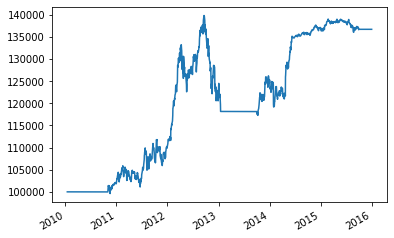

In [6]:
result.portfolio_value.plot()

<AxesSubplot:>

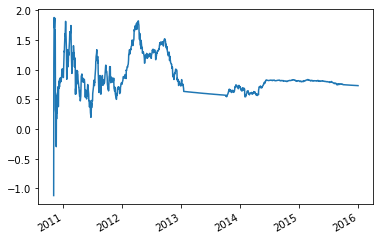

In [12]:
result['sharpe'].plot()

### Single asset backtest with bulk signals

In [9]:
%%capture kltr
start = '2010-01-15'
end = '2016-01-01'
capital_base = 100000
symb = 'AAPL'
window = 90

def initialize(context):
    context.i = 0
    #set_benchmark(symbol(symb))
    #sids = bundle_data.asset_finder.sids
    context.asset = symbol(symb)
    #signal_generator(asset.symbol, rsitype=3, keltner_window=90, ma_long=long_window, ma_short=4, ad_window=ad_window)
    slist = signal_generator(symb, rsitype=3, keltner_window=window, ma_long=30, ad_window=10)
    signals = slist.signal
    buys = [signals[i] if (signals[i]>0) and (slist.ER[i]<0.4) else 0 for i in range(len(signals))]
    sells = [signals[i] if (signals[i]<0) and (slist.ER[i]>0) else 0 for i in range(len(signals))]
    context.signals = pd.Series([b+s for b,s in zip(buys,sells)], index=slist.index)
    context.i = 0
    
def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < window+1:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    #cash = min(context.portfolio.cash, 20000)
    cash = context.portfolio.cash
    price = data.current(context.asset, "price")
    #open_orders = get_open_orders()
    current_date = data.history(context.asset, 'price', bar_count=2, frequency="1d").index[-1]
    
    if context.signals[current_date]>=1:
        # 1 signal means upward trend
        #order_target(context.asset, cash*(context.signals[current_date]/3)//price)
        order_target(context.asset, cash//price)
    elif context.signals[current_date]<=-1:
        # Assume downward trend and sell off
        order_target(context.asset, 0)
    else:
        pass
    
    record(price=data.current(context.asset, 'price'))
    
    # record(COLS=data.history(context.asset, ['open', 'high', 'low', 'close'], bar_count=30, frequency="1d").columns,
    #       INDS=data.history(context.asset, 'close', bar_count=30, frequency="1d").index[-1])


result = run_algorithm(start=pd.Timestamp(start, tz='utc'),
                        end=pd.Timestamp(end, tz='utc'),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='dsebundle',
                        data_frequency='daily',
                        )

## Get the coins and directories

In [10]:
data_dir = os.path.join(os.path.expanduser('~'), 'repos/zipline-technical-analysis/data/crypto/minute/')
save_dir = os.path.join(os.path.expanduser('~'), 'repos/zipline-technical-analysis/data/crypto1/data/')
cz_dir = os.path.join(os.path.expanduser('~'), 'repos/zipline-technical-analysis/data/czday/')

In [11]:
# Cleaning all files in the folder
csv_files = glob.glob(os.path.join(cz_dir, "*.csv"))
coins = []
# loop over the list of csv files
for f in csv_files:
    filename = f.split("/")[-1].split(".")[0]
    coins.append(filename)

## Volume indicators

In [12]:
# VWAP
def get_vwap(df, window=1440):
    df = df.loc[df.index[(-1*window):]]
    avg = (df.close + df.high + df.low)/3
    vavg = df.volume*avg
    cum_vavg = vavg.cumsum()
    cumvol = df.volume.cumsum()
    vwap = cum_vavg/cumvol
    return vwap

def rolling_vwap(df, window=1440, start=None, end=None):
    df["vwap"] = None
    start_loc = df.index.get_loc(start)-window if start else window
    end_loc = df.index.get_loc(end) if end else len(df.index)-1
    for i in df.index[start_loc:end_loc]:
        vw = get_vwap(df.loc[:i], window)
        #print(i, window, vw[-1])
        df.loc[i, "vwap"] = vw[-1]
    return df

# Money flow index
def get_money_flow(df, window=200):
    df = df.loc[df.index[(-1*window):]]
    avg = (df.close + df.high + df.low)/3
    mflow = df.volume*avg
    if avg[-1]>avg[-2]: 
        return mflow[-1]
    elif avg[-1]<avg[-2]:
        return -1*mflow[-1]
    else:
        return 0

def rolling_money_flow(df, window=100):
    df["pmfi"] = 0
    df["nmfi"] = 0
    for i in df.index[window:]:
        mf = get_money_flow(df.loc[:i], 5)
        if mf>0:
            df.pmfi[i] = mf
        elif mf<0:
            df.nmfi[i] = abs(mf)
        
    cp_mfi = df.pmfi.rolling(window).sum()
    cn_mfi = df.nmfi.rolling(window).sum()
    mfi = 100 * (np.array(cp_mfi) / (np.array(cp_mfi)  + np.array(cn_mfi)))
    return pd.Series(index=df.index, data=mfi)

def big_moves_signal(vd, top_hits=4):
    svol = (vd.volume-vd.volume.mean())/vd.volume.std()
    bars = vd.close-vd.open
    sbar = (bars-bars.mean())/bars.std()
    volbar = svol*sbar
    score_threshold = volbar.sort_values(ascending=False)[top_hits-1]
    return volbar[-1]>score_threshold

"""
Entry conditions:
1. Close above vwap line
2. Large breakout bar/trend
3. Last bar/second last bar in consolidation zone
"""
def vwap_entry_signal(df, minute, window=23):
    vw = get_vwap(df, window)
    if (df.close.loc[minute]>vw.loc[minute]): #& (df.open[minute]<vw.loc[minute])
        return 1
    else:
        return 0

def vwap_exit_signal(df, minute, window=23):
    vw = get_vwap(df, window)
    if (df.close.loc[minute]<vw.loc[minute]) & (df.open[minute]>vw.loc[minute]):
        return -1
    elif (df.close.loc[minute]>vw.loc[minute]):
        return 1
    else:
        return 0
    # Continue if condition 1 satisfied

In [13]:
# Testing breakout bar/trend tracker
def bar_moves_signal(vd, top_hits=4):
    svol = (vd.volume-vd.volume.mean())/vd.volume.std()
    bars = vd.close-vd.open
    sbar = (bars-bars.mean())/bars.std()
    volbar = svol*sbar
    score_threshold = volbar.sort_values(ascending=False)[top_hits-1]
    return volbar[-1]>score_threshold

def rolling_bar_moves(slc, timerange, window=100, top_hits=4):
    signals = pd.Series(index=slc.index, data=[0 for n in slc.index])
    for minute in timerange:
        signals.loc[minute] = bar_moves_signal(slc.loc[(slc.index<=minute) & (slc.index> minute - timedelta(minutes=window))], top_hits)
    return signals

def rolling_vwap(df, window=1440, start=None, end=None):
    df["vwap"] = None
    start_loc = df.index.get_loc(start)-window if start else window
    end_loc = df.index.get_loc(end) if end else len(df.index)-1
    for i in df.index[start_loc:end_loc]:
        vw = get_vwap(df.loc[:i], window)
        #print(i, window, vw[-1])
        df.loc[i, "vwap"] = vw[-1]
    return df


def candle_mtm_plot(df, midpoint, hour_range=1, volume_profile=False, mtm=False, breakouts=True):
    ## Adding data to volume subplot
    x1 = midpoint
    start = pd.Timestamp(x1, tz="utc")-timedelta(hours=hour_range)
    end = pd.Timestamp(x1, tz="utc")+timedelta(hours=hour_range)
    mtm_cutoff = 100
    if volume_profile==True:
        volprofile, bucket_size = get_volume_profile(df, midpoint, hour_range=1, from_mid=True)
    
    df["ma_vol"] = df.volume.rolling(25).mean()
    df["ma_vol_high"] = df.volume.rolling(25).mean() + (2*df.volume.rolling(99).std())
    df = df.loc[(df.index>=start) & (df.index<end)]
        
    if mtm==True:
        mtum, mtma = mpq.MTM(df.close, 3, 2)
        bars = bar_moves_signal(df, 5)
        consolidates = mtum.loc[(mtum>-mtm_cutoff)&(mtum<mtm_cutoff)].index
        #df["consolids"] = [mtum.loc[i] if i in consolidates else np.nan for i in df.index]
        df["consolids"] = [df.close.loc[i]+50 if i in consolidates else np.nan for i in df.index]

        momentum = mpf.make_addplot(df["consolids"], color="blue", type="scatter", marker=">",markersize=100)
    
    window = 100
    timerange = pd.date_range(start=df.index[df.index.get_loc(start)-window], end=end, freq='min', tz='utc')
    if breakouts==True:
        break_sigs = rolling_bar_moves(df, timerange)
        breakdates = break_sigs.loc[break_sigs==True].index
        breaksignals = [df.close.loc[i]+50 if (i in breakdates) & ((df.close.loc[i]>df.vwap.loc[i]) & (df.open.loc[i]<df.vwap.loc[i])) else np.nan for i in df.index]
        plotbreaks = mpf.make_addplot(breaksignals, color="blue", type="scatter", marker=">",markersize=100)
        
    vol_low = mpf.make_addplot(df["ma_vol"], color="purple", panel=1)
    vol_high = mpf.make_addplot(df["ma_vol_high"], color="black", panel=1)
    vwap = mpf.make_addplot(df["vwap"], color="red", width=1.5)
    #print(len(df["consolids"]), len(df))
    fig, axlist = mpf.plot(
            df,
            type='candle',
            addplot = [vwap, vol_low, vol_high, plotbreaks],
            style='charles',
            title=midpoint,
            ylabel='Price ($)',
            volume=True,
            figscale=1.2,
            returnfig=True,
            tight_layout=True,
            figsize=(22,10),
        )
        
    #Volume profile
    if volume_profile==True:
        vpax = fig.add_axes(axlist[0].get_position())
        vpax.set_axis_off()
        vpax.set_xlim(right=1.2*max(volprofile.values))
        vpax.barh( volprofile.keys().values, volprofile.values, height=0.75*bucket_size, align='center', color='cyan', alpha=0.35)

    mpf.show()
    return df

## Backtest like zipline

In [2]:
def backtest_minute(minute, df, pnl, i, position, ordered, max_price):
    i += 1
    if i<100:
        return backtest_minute(minute, df, pnl, i, position, ordered, max_price)
    # Minute can be on any day
    myd = df.loc[(df.index<=minute)]
    signal = big_moves_signal(myd)
    price = myd.close[minute]
    # # timed exit
    # if (position>0) and ((minute-ordered).seconds==120):
    #     signal = -1
    #     print("timed exit")
    # trailing stop
    if (position>0):
        if price > max_price:
            max_price = price
        elif price < max_price*0.99:
            signal = -1
    # Buy
    if signal==1:
        if position!=0:
            pnl += (price-position)
        ordered = minute
        position = price
        max_price = price
        print("Buying at", price)
    # Sell
    elif (signal==-1) & (position!=0):
        print("Selling at", ((price-position)*100)/position)
        pnl += (price - position)
        position = 0
        ordered = 0
    return pnl, i, position, ordered, max_price, signal

def backtest_single(df):
    df = df.sort_index()
    pnl = 0
    i = 0
    position = 0
    window = 100
    max_price = 0
    ordered = df.index[0]
    for minute in df.index[window:]:
        pnl, i, position, ordered, max_price = backtest_minute(minute, df, pnl, i, position, ordered, max_price)
    return pnl

def append_df(stock, data_dir):
    df = asset_df(stock, data_dir).sort_index().drop(columns=["timestamp"])
    return df

def data_hist(stocks, data_dir):
    ms = {stock:append_df(stock, data_dir) for stock in stocks}
    return ms

def all_true(bools):
    for boolean in bools:
        if boolean<=0:
            return False 
    return True

def prior_consolidation_signal(df, minute, last=2, window=4, mtm_cutoff=100):
    df = df.loc[df.index[(-2*window):]]
    min_n1 =  minute - timedelta(minutes=1)
    min_n2 =  minute - timedelta(minutes=2)
    mtum, mtma = mpq.MTM(df.close, window-1, window-2)
    sig = 0
    if (mtum.loc[min_n1]>-mtm_cutoff)&(mtum.loc[min_n1]<mtm_cutoff):
        sig = 1
    if (mtum.loc[min_n2]>-mtm_cutoff)&(mtum.loc[min_n2]<mtm_cutoff):
        sig = 1
    return 1 if sig>0 else 0


def daily_stats(buys, sells, wins, losses, risks, rewards, daytrend):
    if risks==0 or losses==0:
        riskavg = 0
    else:
        riskavg = risks/(losses)
    if rewards==0 or wins==0:
        rewardavg = 0
    else:
        rewardavg = rewards/(wins)
    print("Buys:", buys, "Sells:", sells, "Wins:", wins, "Losses:", losses, "Risk:", riskavg, "Rewards:", rewardavg, "daytrend:", daytrend)
    print(f"Win ratio = {wins/(wins+losses)} Risk:Reward = {round(riskavg/rewardavg,2)}:1")
    print("----------------------------------------------------------------")

def backtest_all(data_dict, timerange, min_consensus = 0.8, window = 100, stop_loss=0.95):
    """
    Backtest simulating zipline
    """
    position = {asset:0 for asset in data_dict.keys()}
    pnl = {asset:0 for asset in data_dict.keys()}
    ordered = {asset:0 for asset in data_dict.keys()}
    max_price = {asset:0 for asset in data_dict.keys()}
    last_price = {asset:0 for asset in data_dict.keys()}
    min_signals = len(data_dict.keys())*min_consensus
    wins = 0
    loses= 0
    rewards = 0
    risks = 0
    buys= 0
    sells=0
    take_profit = 1.06
    next_day = timerange[window+1440]
    ref_asset = data_dict['BTCUSDT']
    opening_price = ref_asset.close.loc[timerange[window]]
    i = 0
    for minute in timerange:
        i += 1
        if i < window:
            continue
        totsig = 0
        tobuy = []
        tosells = []
        hist = data_dict

        # First check how many coins are displaying signals for current minute
        for asset in hist.keys():
            # Find corresponding signal
            slc = hist[asset]
            last_price[asset] = slc.close[minute]
            #sig = big_moves_signal(slc.loc[(slc.index<=minute) & (slc.index> minute - timedelta(minutes=window))], 5)
            breakbar = bar_moves_signal(slc.loc[(slc.index<=minute) & (slc.index> minute - timedelta(minutes=window))], 5)
            vwap_cross = vwap_entry_signal(slc.loc[(slc.index<=minute) & (slc.index> minute - timedelta(minutes=window))], minute)
            consolidated = prior_consolidation_signal(slc.loc[(slc.index<=minute) & (slc.index> minute - timedelta(minutes=window))], minute, last=2)
            totsig += all_true([breakbar,vwap_cross,consolidated])
            tobuy.append(asset) if all_true([breakbar,vwap_cross,consolidated]) else None
        # Buy if enough signals received
        if totsig>=min_signals:
            #print("Buying up", str(tobuy), "at time", minute)
            for asset in tobuy:
                price = last_price[asset]
                if position[asset]!=0:
                    tosells.append(asset)
                    gain = price-position[asset]
                    pnl[asset] += (price-position[asset])
                    sells+=1
                    buys+=1
                    #print("Gains", gain)
                    if gain>0:
                        wins += 1
                        rewards += gain
                    elif gain<=0:
                        loses += 1
                        risks += abs(gain)
                position[asset] = price
                max_price[asset] = price*take_profit
                buys+=1
        
        # Sell on trailing stop loss
        for asset in position.keys():
            if position[asset]>0:
                price = last_price[asset]
                if price > max_price[asset]:
                    max_price[asset] = price
                elif price < (max_price[asset] * stop_loss):
                    # Sell
                    gain = price - position[asset]
                    #print("Stop loss sell:", asset, ", gained:", gain, "minute:", minute)
                    pnl[asset] += gain
                    sells+=1
                    if gain>0:
                        wins += 1
                        rewards += gain
                    elif gain<=0:
                        loses += 1
                        risks += abs(gain)
                    tosells.append(asset)
                    position[asset] = 0
                    # ordered[asset] = 0
                    max_price[asset] = 0
        # Output some daily stats to watch while backtest runs
        if minute==next_day:
            daytrend = (ref_asset.close.loc[minute] - opening_price)
            daily_stats(buys,sells, wins, loses, risks, rewards, daytrend)
            opening_price = ref_asset.close.loc[minute]
            next_day = minute+timedelta(days=1)
            #print("Setting new day")
            wins = 0
            loses= wins
            rewards = wins
            risks = wins
            buys= 0
            sells=0
    for k, v in pnl.items():
        gain = pnl[k]
        pnl[k] = gain*100/last_price[k]
    print("Final pnl:", sum(pnl.values()))
    return pnl

def backtest_vwap(data_dict, timerange, min_consensus = 0.8, window = 100, stop_loss=0.98, take_profit = 1.06):
    """
    Backtest simulating zipline
    """
    position = {asset:0 for asset in data_dict.keys()}
    pnl = {asset:0 for asset in data_dict.keys()}
    ordered = {asset:0 for asset in data_dict.keys()}
    max_price = {asset:0 for asset in data_dict.keys()}
    last_price = {asset:0 for asset in data_dict.keys()}
    profit_reached = {asset:0 for asset in data_dict.keys()}
    min_signals = len(data_dict.keys())*min_consensus
    wins = 0
    loses= 0
    rewards = 0
    risks = 0
    buys= 0
    sells=0
    next_day = timerange[window+1440]
    ref_asset = data_dict['BTCUSDT']
    opening_price = ref_asset.close.loc[timerange[window]]
    i = 0
    for minute in timerange:
        i += 1
        if i < window:
            continue
        totsig = 0
        tobuy = []
        tosells = []
        hist = data_dict

        # First check how many coins are displaying signals for current minute
        for asset in hist.keys():
            # Find corresponding signal
            slc = hist[asset]
            last_price[asset] = slc.close[minute]
            #sig = big_moves_signal(slc.loc[(slc.index<=minute) & (slc.index> minute - timedelta(minutes=window))], 5)
            breakbar = bar_moves_signal(slc.loc[(slc.index<=minute) & (slc.index> minute - timedelta(minutes=window))], 5)
            vwap_cross = vwap_entry_signal(slc.loc[(slc.index<=minute) & (slc.index> minute - timedelta(minutes=window))], minute)
            consolidated = prior_consolidation_signal(slc.loc[(slc.index<=minute) & (slc.index> minute - timedelta(minutes=window))], minute, last=2)
            totsig += all_true([breakbar,vwap_cross,consolidated])
            tobuy.append(asset) if all_true([breakbar,vwap_cross,consolidated]) else None
            # Sell logic
            tosells.append(asset) if vwap_cross==-1 else None
        # Buy if enough signals received
        if totsig>=min_signals:
            #print("Buying up", str(tobuy), "at time", minute)
            for asset in tobuy:
                price = last_price[asset]
                if position[asset]!=0:
                    #tosells.append(asset)
                    gain = price-position[asset]
                    pnl[asset] += (price-position[asset])
                    sells+=1
                    buys+=1
                    #print("Gains", gain)
                    if gain>0:
                        wins += 1
                        rewards += gain
                    elif gain<=0:
                        loses += 1
                        risks += abs(gain)
                position[asset] = price
                max_price[asset] = price*take_profit
                profit_reached[asset] = 0
                buys+=1
        
        # Sell on trailing stop loss
        for asset in position.keys():
            if (position[asset]>0):
                price = last_price[asset]
                if price > max_price[asset]:
                    max_price[asset] = price
                    profit_reached[asset] = 1
                elif ((price < (max_price[asset] * stop_loss)) & (profit_reached[asset]==1)) | (asset in tosells):
                    # Sell
                    gain = price - position[asset]
                    #print("Stop loss sell:", asset, ", gained:", gain, "minute:", minute)
                    pnl[asset] += gain
                    sells+=1
                    if gain>0:
                        wins += 1
                        rewards += gain
                    elif gain<=0:
                        loses += 1
                        risks += abs(gain)
                    #tosells.append(asset)
                    position[asset] = 0
                    # ordered[asset] = 0
                    max_price[asset] = 0
        # Output some daily stats to watch while backtest runs
        if minute==next_day:
            daytrend = (ref_asset.close.loc[minute] - opening_price)
            daily_stats(buys,sells, wins, loses, risks, rewards, daytrend)
            opening_price = ref_asset.close.loc[minute]
            next_day = minute+timedelta(days=1)
            #print("Setting new day")
            wins = 0
            loses= wins
            rewards = wins
            risks = wins
            buys= 0
            sells=0
    for k, v in pnl.items():
        gain = pnl[k]
        pnl[k] = gain*100/last_price[k]
    print("Final pnl:", sum(pnl.values()))
    return pnl

In [20]:
data_btc = data_hist(['BTCUSDT'], data_dir)
timerange = pd.date_range(start='2022-10-27 02:58:00+00:00', end='2022-11-27 08:11:00+00:00', freq='min', tz='utc')
backtest_vwap(data_btc, timerange, min_consensus = 1, window = 100, stop_loss=0.99)

Buys: 65 Sells: 32 Wins: 21 Losses: 11 Risk: 104.52272727272826 Rewards: 28.810952380952845 daytrend: -489.5699999999997
Win ratio = 0.65625 Risk:Reward = 3.63:1
----------------------------------------------------------------
Buys: 98 Sells: 49 Wins: 37 Losses: 12 Risk: 42.45416666666673 Rewards: 27.915405405405476 daytrend: 388.01000000000204
Win ratio = 0.7551020408163265 Risk:Reward = 1.52:1
----------------------------------------------------------------
Buys: 104 Sells: 52 Wins: 40 Losses: 12 Risk: 80.60249999999967 Rewards: 23.718249999999898 daytrend: 103.69999999999709
Win ratio = 0.7692307692307693 Risk:Reward = 3.4:1
----------------------------------------------------------------
Buys: 72 Sells: 36 Wins: 18 Losses: 18 Risk: 39.81277777777804 Rewards: 26.017222222222497 daytrend: -239.2599999999984
Win ratio = 0.5 Risk:Reward = 1.53:1
----------------------------------------------------------------
Buys: 90 Sells: 45 Wins: 33 Losses: 12 Risk: 67.3149999999996 Rewards: 23.879

{'BTCUSDT': -25.6785321517343}